In [1]:
# Copyright (c) Meta Platforms, Inc. and affiliates.

# All rights reserved to Meta Platforms, Inc. and affiliates.
# This is only an educational notebook. Please follow [SAM2 repo license](https://github.com/facebookresearch/segment-anything-2)

# Patch locating with Video segmentation with SAM 2

This notebook shows how to use SAM 2 for patch relocation. It will cover the following:

- create fake frames with target query image (frame-0) and the base image (frame-1).
- adding bbox on the target query image in frame-0 and propagating to get _masklets_ in the frame (spatio-temporal masks) 
- propagating bboxes to get _masklets_ throughout the video
- segmenting and tracking the object

We use the terms _segment_ or _mask_ to refer to the model prediction for an object on a single frame, and _masklet_ to refer to the spatio-temporal masks across the entire video. 

If running locally using jupyter, first install `segment-anything-2` in your environment using the [installation instructions](https://github.com/facebookresearch/segment-anything-2#installation) in the repository.

In [1]:
import os
import torch
import numpy as np
import matplotlib.pyplot as plt
from PIL import Image

In [2]:
# use bfloat16 for the entire notebook
torch.autocast(device_type="cuda", dtype=torch.bfloat16).__enter__()

if torch.cuda.get_device_properties(0).major >= 8:
    # turn on tfloat32 for Ampere GPUs (https://pytorch.org/docs/stable/notes/cuda.html#tensorfloat-32-tf32-on-ampere-devices)
    torch.backends.cuda.matmul.allow_tf32 = True
    torch.backends.cudnn.allow_tf32 = True

### Loading the SAM 2 video predictor

In [3]:
from sam2.build_sam import build_sam2_video_predictor

sam2_checkpoint = "../checkpoints/sam2_hiera_large.pt"
model_cfg = "sam2_hiera_l.yaml"

predictor = build_sam2_video_predictor(model_cfg, sam2_checkpoint)

In [4]:
def show_mask(mask, ax, obj_id=None, random_color=False):
    if random_color:
        color = np.concatenate([np.random.random(3), np.array([0.6])], axis=0)
    else:
        cmap = plt.get_cmap("tab10")
        cmap_idx = 0 if obj_id is None else obj_id
        color = np.array([*cmap(cmap_idx)[:3], 0.6])
    h, w = mask.shape[-2:]
    mask_image = mask.reshape(h, w, 1) * color.reshape(1, 1, -1)
    ax.imshow(mask_image)


def show_points(coords, labels, ax, marker_size=200):
    pos_points = coords[labels==1]
    neg_points = coords[labels==0]
    ax.scatter(pos_points[:, 0], pos_points[:, 1], color='green', marker='*', s=marker_size, edgecolor='white', linewidth=1.25)
    ax.scatter(neg_points[:, 0], neg_points[:, 1], color='red', marker='*', s=marker_size, edgecolor='white', linewidth=1.25)   

#### Create a dummy video with 2 frames

In [5]:
og_file = "images/mobile.png"
cropped_file = "images/crop2.png"
og_image = Image.open(og_file).convert("RGB")
cropped_image = Image.open(cropped_file).convert("RGB")


In [6]:
# `video_dir` a directory of JPEG frames with filenames like `<frame_index>.jpg`
video_dir = "./videos/crops"
# create the video directory if it doesn't exist
os.makedirs(video_dir, exist_ok=True)


In [7]:
def paste_image_on_blank_background(image, background_color=(255, 255, 255), new_image_size=None):
    """
    Paste the image on a blank background with the specified color.
    """
    assert new_image_size is not None, "Please specify the new image size."
    assert new_image_size[0] >= image.size[0], "The new image width should be greater than or equal to the image width."
    assert new_image_size[1] >= image.size[1], "The new image height should be greater than or equal to the image height."
    new_image = Image.new("RGB", (new_image_size[0], new_image_size[1]), background_color)
    new_image.paste(image, (0, 0))
    coords = (0, 0, image.size[0], image.size[1])
    return new_image, coords

def create_fake_frames(image, cropped_image, output_dir):
    """
    Create fake frames for the image.
    """
    original_image_width, original_image_height = image.size
    cropped_image_width, cropped_image_height = cropped_image.size

    if cropped_image_width > original_image_width:
        # Resize the cropped image to match the width of the original image while maintaining the aspect ratio
        ratio = original_image_width / cropped_image_width
        new_width = int(cropped_image_width * ratio)
        new_height = int(cropped_image_height * ratio)
        cropped_image = cropped_image.resize((new_width, new_height))

    dummy_frame_with_crop, cropped_image_bbox = paste_image_on_blank_background(cropped_image, new_image_size=(original_image_width, original_image_height))
    # save the dummy frame with crop
    dummy_frame_with_crop.save("videos/crops/0.jpg")
    image.save("videos/crops/1.jpg")
    return cropped_image_bbox

In [8]:
bbox = create_fake_frames(og_image, cropped_image, video_dir)

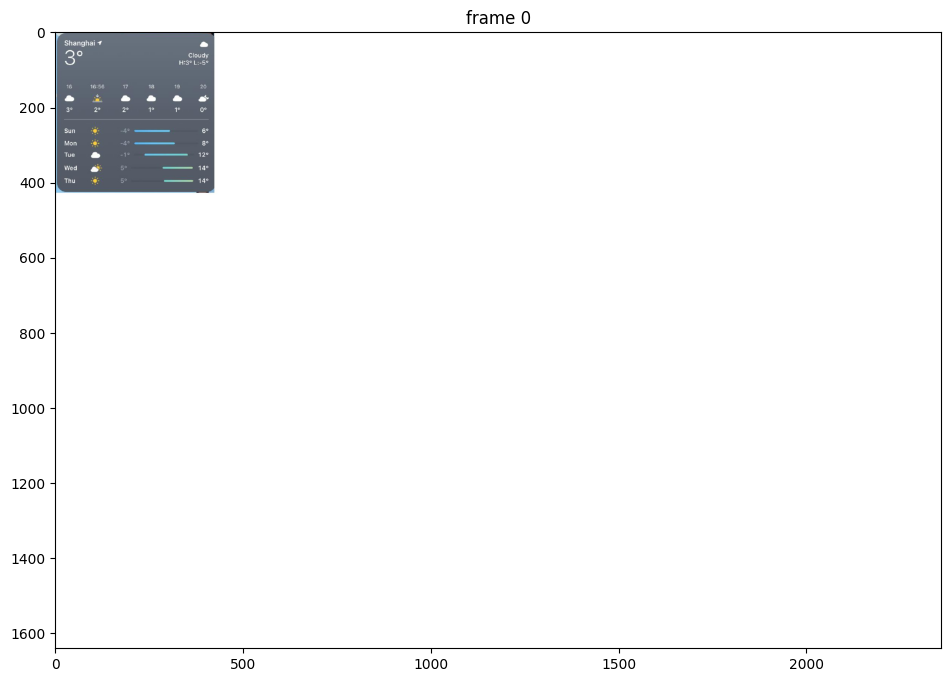

In [9]:


# scan all the JPEG frame names in this directory
frame_names = [
    p for p in os.listdir(video_dir)
    if os.path.splitext(p)[-1] in [".jpg", ".jpeg", ".JPG", ".JPEG", ".png"]
]
frame_names.sort(key=lambda p: int(os.path.splitext(p)[0]))

# take a look the first video frame
frame_idx = 0
plt.figure(figsize=(12, 8))
plt.title(f"frame {frame_idx}")
plt.imshow(Image.open(os.path.join(video_dir, frame_names[frame_idx])))

#### Initialize the inference state

SAM 2 requires stateful inference for interactive video segmentation, so we need to initialize an **inference state** on this video.

During initialization, it loads all the JPEG frames in `video_path` and stores their pixels in `inference_state` (as shown in the progress bar below).

In [10]:
inference_state = predictor.init_state(video_path=video_dir)

frame loading (JPEG): 100%|██████████| 2/2 [00:00<00:00,  9.38it/s]


### Example 1: Segment & track one object

Note: if you have run any previous tracking using this `inference_state`, please reset it first via `reset_state`.

(The cell below is just for illustration; it's not needed to call `reset_state` here as this `inference_state` is just freshly initialized above.)

In [11]:
predictor.reset_state(inference_state)

#### Step 1: Add a first click on a frame

To get started, let's try to segment the child on the left.

Here we make a **positive click** at (x, y) = (210, 350) with label `1`, by sending their coordinates and labels into the `add_new_points` API.

Note: label `1` indicates a *positive click (to add a region)* while label `0` indicates a *negative click (to remove a region)*.

One can also provide bounding boxes instead of clicks. I am going with clicks here.

In [ ]:
ann_frame_idx = 0  # the frame index we interact with
ann_obj_id = 1  # give a unique id to each object we interact with (it can be any integers)


# Let's add a positive click at (x, y) = (210, 350) to get started
points = np.array([ [ (bbox[0] + bbox[2])/2, (bbox[1] + bbox[3])/2 ] ], dtype=np.float32)
# for labels, `1` means positive click and `0` means negative click
labels = np.array([1], np.int32)
_, out_obj_ids, out_mask_logits = predictor.add_new_points(
    inference_state=inference_state,
    frame_idx=ann_frame_idx,
    obj_id=ann_obj_id,
    points=points,
    labels=labels,
)

# show the results on the current (interacted) frame
plt.figure(figsize=(12, 8))
plt.title(f"frame {ann_frame_idx}")
plt.imshow(Image.open(os.path.join(video_dir, frame_names[ann_frame_idx])))
show_points(points, labels, plt.gca())
show_mask((out_mask_logits[0] > 0.0).cpu().numpy(), plt.gca(), obj_id=out_obj_ids[0])

#### Step 2: Add a second click to refine the prediction

There could be ambiguity from a single click about what the target object should be. We can refine the mask on this frame via another positive click. For the first click, I used the center of the bbox.

You can make a **second positive click** at (x, y) anywhere inside the bbox with label `1` to expand the mask.

Note: we need to send **all the clicks and their labels** (i.e. not just the last click) when calling `add_new_points`.

Uncomment the cell below it if you want to add more points

In [ ]:
# ann_frame_idx = 0  # the frame index we interact with
# ann_obj_id = 1  # give a unique id to each object we interact with (it can be any integers)

# # Let's add a 2nd positive click at (x, y) = (250, 220) to refine the mask
# # sending all clicks (and their labels) to `add_new_points`
# points = np.array([[210, 350], [250, 220]], dtype=np.float32)
# # for labels, `1` means positive click and `0` means negative click
# labels = np.array([1, 1], np.int32)
# _, out_obj_ids, out_mask_logits = predictor.add_new_points(
#     inference_state=inference_state,
#     frame_idx=ann_frame_idx,
#     obj_id=ann_obj_id,
#     points=points,
#     labels=labels,
# )

# # show the results on the current (interacted) frame
# plt.figure(figsize=(12, 8))
# plt.title(f"frame {ann_frame_idx}")
# plt.imshow(Image.open(os.path.join(video_dir, frame_names[ann_frame_idx])))
# show_points(points, labels, plt.gca())
# show_mask((out_mask_logits[0] > 0.0).cpu().numpy(), plt.gca(), obj_id=out_obj_ids[0])

With this 2nd refinement click, now we can get a refined segmentation mask of the entire target query image on frame 0.

#### Step 3: Propagate the prompts to get the masklet across the video

To get the masklet throughout the entire video, we propagate the prompts using the `propagate_in_video` API.

In [ ]:
# run propagation throughout the video and collect the results in a dict
video_segments = {}  # video_segments contains the per-frame segmentation results
for out_frame_idx, out_obj_ids, out_mask_logits in predictor.propagate_in_video(inference_state):
    video_segments[out_frame_idx] = {
        out_obj_id: (out_mask_logits[i] > 0.0).cpu().numpy()
        for i, out_obj_id in enumerate(out_obj_ids)
    }

# render the segmentation results every few frames
vis_frame_stride = 1
plt.close("all")
for out_frame_idx in range(0, len(frame_names), vis_frame_stride):
    plt.figure(figsize=(6, 4))
    plt.title(f"frame {out_frame_idx}")
    plt.imshow(Image.open(os.path.join(video_dir, frame_names[out_frame_idx])))
    for out_obj_id, out_mask in video_segments[out_frame_idx].items():
        show_mask(out_mask, plt.gca(), obj_id=out_obj_id)

#### Step 4: Add new prompts to further refine the masklet

It appears that in the output masklet above, there are some imperfections in boundary details on frame 150.

With SAM 2 we can fix the model predictions interactively. We can add a **negative click**, if you think segmentation mask is extending to places it shouldn't, on this frame with label `0` to refine the masklet. Here we call the `add_new_points` API with a different `frame_idx` argument to indicate the frame index we want to refine.

#### Step 5: You can also track multiple objects by adding them on frame 0 and providing their bboxes/clicks